# Лабораторная работа №5

Подготовили :
- Залесская Галя;
- Максимов Артем;
- Соколова Света;
- Шилов Слава.

In [0]:
from lxml import objectify, etree, html
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Часть 0. Сбор и объединение данных




In [0]:
#Old data
!cp drive/'My Drive'/Lab5_data/catalog.xml       . #Slava
!cp drive/'My Drive'/Lab5_data/new_articles.xml  . #Sveta
!cp drive/'My Drive'/Lab5_data/Zalesskaya.xml    . #Galya
!cp drive/'My Drive'/Lab5_data/output_ent.xml    . #Artem

#Updated data
!cp drive/'My Drive'/Lab5_data/output_ent_updated.xml  . #Artem
!cp drive/'My Drive'/Lab5_data/catalog_updated.xml     . #Slava  
!cp drive/'My Drive'/Lab5_data/output2.xml             . #Galya 
!cp drive/'My Drive'/Lab5_data/updated_articles.xml    . #Sveta

## Слияние всех файлов в 1 датасет:

In [0]:
def prepare_data():

  all_data = ['output_ent.xml','catalog.xml','new_articles.xml','Zalesskaya.xml']
  all_data_upd = ['output_ent_updated.xml', 'catalog_updated.xml', 'output2.xml', 'updated_articles.xml']
  catalog = []
  #fetch all data
  for data in all_data + all_data_upd:
    xmlstr_ent = open(data).read()
    root_ent = etree.fromstring(xmlstr_ent)

    for element_lvl1 in root_ent:
        news = {}
        for element_lvl2 in element_lvl1:
            if element_lvl2.tag == 'tag':
              element_lvl2.tag = 'tags'
            txt = element_lvl2.text
            news[element_lvl2.tag] = '' if txt is None else txt

        if news['text'] not in [n['text'] for n in catalog]:
          catalog.append(news)

  #Каждый из нас называл категории по-разному(например 'UK' и 'uk')
  #Для того чтобы использовать старые файлы необходимо слить их вместе
  #Изменение самих xml'ек кажется нецелесообразным, тк эти файлы не будут переиспользованы
 
  #Проделанные изменения:
  #sports -> sport
  #UK & Royal -> uk
  #Science & technology -> science
  #World -> world

  for news in catalog:
    if news['category'] == 'sports':
      news['category'] = 'sport'
    if news['category'] == 'UK':
      news['category'] = 'uk'
    if news['category'] == 'Royal':
      news['category'] = 'uk'
    if news['category'] == 'Science':
      news['category'] = 'science'
    if news['category'] == 'technology':
      news['category'] = 'science'
    if news['category'] == 'World':
      news['category'] = 'world'

  categories = set([news['category'] for news in catalog])
  counts = dict.fromkeys(list(categories), 0)
  for news in catalog:
    counts.update({news['category'] : counts[news['category']] + 1})
  print(counts)

  return catalog

In [0]:
data = prepare_data()

{'health': 99, 'uk': 470, 'world': 365, 'entertainment': 94, 'business': 212, 'travel': 70, 'sport': 229, 'science': 153}


Как видно, распределение новостей по топикам не равномерно и это может как-то сказаться на результатах(слов, связанных с 'entertainment', меньше чем связанных со 'sport'), но обрезание датасета не вариант, тк тогда данных будет маловато

In [0]:
len(data)

1692

In [0]:
texts  = set([news['text'] for news in data])
print(len(texts))

1692


По итогу мы имеем 1692 уникальных новости

## Предобработка данных


Как всегда первым делом данные надо предобработать для упрощения работы и уменьшения размера словаря.

Был переиспользован код из предыдущих лаб:

In [0]:
import nltk
nltk.download()
#d wordnet
#d stopwords
#q

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d wordnet
      Unzipping corpora/wordnet.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [0]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

def tokenize(input):
  tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
  return tokenizer.tokenize(input)

def remove_stop_words(input):
  stop_words = set(stopwords.words('english'))
  return [w for w in input if not w in stop_words]
  
def try_lemmatize(word, pos):
  lemmatizer = WordNetLemmatizer()
  return lemmatizer.lemmatize(word, pos = pos)

def lemmatize(input):
  output = []
  poses = ["n", "a", "v"]
  for word in input:
    Flag = False
    for pos in poses:
      if not Flag:
        result = try_lemmatize(word,pos)
        if result != word:
          Flag = True
          output.append(result)
    if not Flag:
      output.append(word)
  return output

def prepare_data(Text, Title, Tags):
  Text  = lemmatize(remove_stop_words(tokenize(Text.lower())))
  Title = lemmatize(remove_stop_words(tokenize(Title.lower())))
  Tags  = lemmatize(remove_stop_words(tokenize(Tags.lower())))
  return Text, Title, Tags

In [0]:
def data_preparation(data):
  prepared_dataset = []
  for i in data:
    Text     = i['text']
    Title    = i['title']
    Tags     = i['tags']
    Category = i['category']
    Text, Title, Tags = prepare_data(Text, Title,Tags)
    prepared_dataset.append([Title, Text, Tags, Category])
  return prepared_dataset

In [0]:
dataset = data_preparation(data)

In [0]:
words = []
for [title, text, _, _] in dataset:
  for word in title+text:
    words.append(word)

len(set(words))

28483

После лемматизации и удаления "стоп слов" размер словаря равен 28483

In [0]:
train_dataset =  [' '.join([*title, *text]) for [title, text, tags,category] in dataset]

# Часть 1. Тематическое моделирование

Для использования LDA данные должны быть представлены в виде term-doc матрицы. 

Для этого воспользуемся CountVectorizer'ом из библиотеки sklearn.

Во время работы мы вдохновлялись данной статьей: https://habr.com/ru/post/417167/


## Count Vectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
voc = {word : i for i,word in enumerate(set(words))}
count_vect = CountVectorizer(vocabulary=voc)
count_vect_matrix = count_vect.fit_transform(train_dataset)

## LDA

Обучим следующие варианты LDA:

- 5 топиков

  Результат ожидается плохой, тк у нас 8 категорий новостей. Из-за этого часть категорий перемешаются

- 8 топиков

  В идеале каждый топик LDA должен совпасть с категорией новостей, но тут мы сталкиваемся с тем, что часть категорий могут быть похожи(например 'world' и 'uk')

- 15 топиков

  Результат сложно предугадать - с одной стороны мы обнаружим более узкие темы, с другой стороны это может повлиять на результат(тк темы LDA могут быть между категориями - например тема 'киберспорт' может включать слова и из 'sport', и из 'entertainment', и из 'technology', если речь идет о каком-нибудь железе)

- 30 топиков

  Ситуация аналогична предыдущему кейсу. Темы будут еще более специфичны

In [0]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [0]:
def check_lda(countVectModel, ldaModel, text, n_keywords, n_topics):
  vect_text = countVectModel.transform([text])
  lda_topics = ldaModel.transform(vect_text)
  lda_topics = np.squeeze(lda_topics, axis=0)
  n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
  top_topics_words_dists = []
  for i in n_topics_indices:
    top_topics_words_dists.append(ldaModel.components_[i])
  keywords = np.zeros(shape=(n_keywords*n_topics, ldaModel.components_.shape[1]))
  for i,topic in enumerate(top_topics_words_dists):
      n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
      for k,j in enumerate(n_keywords_indices):
          keywords[i * n_keywords + k, j] = 1
  keywords = count_vect.inverse_transform(keywords)
  keywords = [keyword[0] for keyword in keywords]
  return [[topic_word for topic_word in keywords[i*n_keywords:i*n_keywords+n_keywords]] for i in range(n_topics)]

Чтобы сравнение моделей было более наглядным, посмотрим, какие ключевые слова подбирают LDA, обученные для разного количества тем, для одной конкретной новости - самой первой из датасета. Она описывает про круизное путешествие по реке Янцзы и относится к теме "Путешествия".

In [0]:
data[0]

{'category': 'travel',
 'tags': 'gorges, yangtze, meters, largest, cruise, chinas, river, ship, sail, feet, square, worlds, victoria',
 'text': '(CNN) — The Yangtze may only be the world\'s third-longest river, but it\'s about to be served by the world\'s biggest river cruise ship.\n\nThe Victoria Sabrina ship will set sail on China\'s largest inland body of water in 2020, ferrying passengers through multiple provinces and providing views of the Three Gorges Dam.\n\nUS-based company Victoria Cruises tells CNN Travel that the Victoria Sabrina, due to make her maiden voyage in 2020, is a luxury ship that combines Western and Chinese design elements.\n\nRelated content World\'s longest cruise sets sail from London\n\nAll staterooms will have balconies, and an open-air observation deck on top of the ship will provide plenty of vantage points and opportunities for enjoying the views.\n\nThere are a range of room choices available. The smallest option is a stateroom, which is 275 square feet

### 5 Topics

In [0]:
lda5 = LDA(n_components = 5,
                 max_iter=30,
                 n_jobs=6,
                 learning_method='batch',
                 verbose=1)
lda5.fit(count_vect_matrix)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=5, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [0]:
[words5] = check_lda(count_vect, lda5, train_dataset[0], 10, 1)
print(words5)

['world', 'photo', 'hide', 'year', 'caption', 'game', 'one', 'first', 'hotel', 'new']


Ключевые слова 'world', 'photo', 'year', 'one', 'first', 'hotel', 'new' вполне соотносятся с темой путешествий, тогда как 'hide', 'caption', 'game' совсем не относятся к этой теме .




### 8 Topics

In [0]:
lda8 = LDA(n_components = 8,
                 max_iter=30,
                 n_jobs=6,
                 learning_method='batch',
                 verbose=1)
lda8.fit(count_vect_matrix)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=8, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [0]:
[words8] = check_lda(count_vect, lda8, train_dataset[0], 10, 1)
print(words8)

['hotel', 'new', 'one', 'city', 'restaurant', 'make', 'food', 'world', 'room', 'year']


Все найденные ключевые слова довольно ожидаемо увидеть в теме про путешествия. Поэтому можно говорить о хорошем разбиении на темы.

### 15 Topics

In [0]:
lda15 = LDA(n_components = 15,
                 max_iter = 30,
                 n_jobs=6,
                 learning_method='batch',
                 verbose=1)
lda15.fit(count_vect_matrix)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=15, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [0]:
[words15] = check_lda(count_vect, lda15, train_dataset[0], 10, 1)
print(words15)

['hotel', 'best', 'caption', 'photo', 'island', 'world', 'hide', 'new', 'city', 'tour']


Данные слова тоже хорошо определяют тему, но и тут есть непонятное 'caption'.

### 30 Topics

In [0]:
lda30 = LDA(n_components = 30,
                 max_iter = 30,
                 n_jobs=6,
                 learning_method='batch',
                 verbose=1)
lda30.fit(count_vect_matrix)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=30, n_jobs=6,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [0]:
[words30] = check_lda(count_vect, lda30, train_dataset[0], 10, 1)
print(words30)

['island', 'world', 'best', 'yacht', 'destination', 'airport', 'bar', 'international', 'reef', 'sea']


Здесь уже, похоже, была найдена более узкая тема, а именно "Водное путешествие", "Морская навигация"

## Использование Word2Vec для выбора лучшей модели


In [0]:
from gensim.models.coherencemodel import CoherenceModel

Мы читаем задание строчка за строчкой и делаем так же :)

У CoherenceModel похоже есть свой LDA, который почему то не совместим с sklearn'овским. На часть с LDA было потрачено довольно много времени, поэтому переделывать все чтобы просто заюзать эту модель не захотелось. В итоге было решено использовать функции, которые определяют похожесть двух листов слов между собой для подсчета когерентности(=похожести)

In [0]:
import gensim.downloader as api

word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Найдем расстояние между облаком определенных lda ключевых слов и нашей темой

In [0]:
ldas = [5, 8, 15, 30]
for i, words in enumerate([words5, words8, words15,words30]):
  res = word_vectors.n_similarity(words, ['travel'])
  print("The coherence of category 'travel' and keywords for {} topics is {}".format(ldas[i], res))

The coherence of category 'travel' and keywords for 5 topics is 0.6117458343505859
The coherence of category 'travel' and keywords for 8 topics is 0.6359748840332031
The coherence of category 'travel' and keywords for 15 topics is 0.6581843495368958
The coherence of category 'travel' and keywords for 30 topics is 0.6447824239730835


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


C точки зрения предобученной модели, именно LDA на 15 тем лучше всего определил ключевые слова для путешествия. В то время как LDA на 5 тем дал худший результат. Ту же картину мы видели во время простого, человеческого анализа.

Найдем расстояние между облаком ключевых слов и темой каждой статьи, для каждого обученного LDA - на 5 темах, 8, 15 и 30.

In [0]:
def get_LDA_result_for_all():
  distance_results = [[],[],[],[]]
  LDAs = [lda5, lda8, lda15, lda30]
  for i, news in enumerate(train_dataset):
    category = data[i]['category']
    for j in range(4):
      [keywords] = check_lda(count_vect, LDAs[j], news, 10, 1)
      words = []
      for key in keywords: #some words is not in vocabluary of the trained model
        if key in word_vectors.vocab:
          words.append(key)
      distance = word_vectors.n_similarity(words, [category])
      distance_results[j].append(distance)
  return distance_results


In [0]:
distance_results = get_LDA_result_for_all()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
import matplotlib.pyplot as plt
def visualize_distances(results):
  plt.figure(figsize=(15,7))
  plt.plot(results[0], color='red')
  plt.plot(results[1], color='orange')
  plt.plot(results[2], color='green')
  plt.plot(results[3], color='blue')
  plt.legend(['lda5', 'lda8', 'lda15', 'lda30'])


Посмотрим, как меняется расстояние от статьи к статье, от lda к lda.

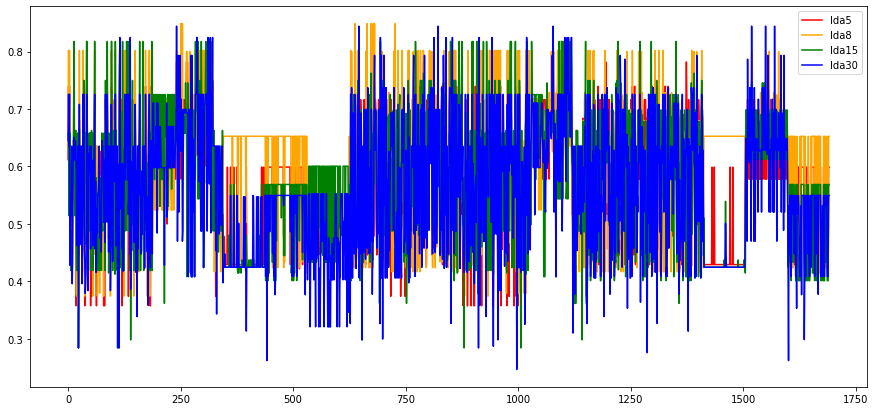

In [0]:
visualize_distances(distance_results)
plt.show()

Результат получился малоинформативным. Единственное, что мы можем увидеть, что некоторые части нашего суммарного датасета определяются хуже остальных. Это связано с разнородностью датасетов, полученных от разных участников команды. Мы могли бы по индексам определить, кто виноват в подобных дропах (например, с 300-го по 600-ый индексы), но не хочется тыкать пальцем, тем более, что, скорее всего, это я)

Чтобы получить более яркую картину, отсортируем наш датасет по категориям, чтобы иметь возможность оценить качество определения каждой темы.

In [0]:
categories = ['travel', 'business', 'health', 'science', 'world', 'uk', 'sport', 'entertainment']
len_categories = []
sorted_train_data = []
train_categories = []

for cat in categories:
  for i, news in enumerate(dataset):
    if data[i]['category'] == cat:
      sorted_train_data.append(' '.join([*news[0], *news[1]]))
      train_categories.append(cat)
  len_categories.append(len(sorted_train_data))

Теперь у нас есть отсортированный датасет sorted_train_data. В train_categories содержится информация о категории каждой новости, а в len_categories - длина каждой категории, которая понадобится нам для визуализации.

In [0]:
sorted_distance_results = [[],[],[],[]]
LDAs = [lda5, lda8, lda15, lda30]
for i, news in enumerate(sorted_train_data):
  category = train_categories[i]
  for j in range(4):
    [keywords] = check_lda(count_vect, LDAs[j], news, 10, 1)
    words = []
    for key in keywords: #some words is not in vocabluary of the trained model
      if key in word_vectors.vocab:
        words.append(key)
    distance = word_vectors.n_similarity(words, [category])
    sorted_distance_results[j].append(distance)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


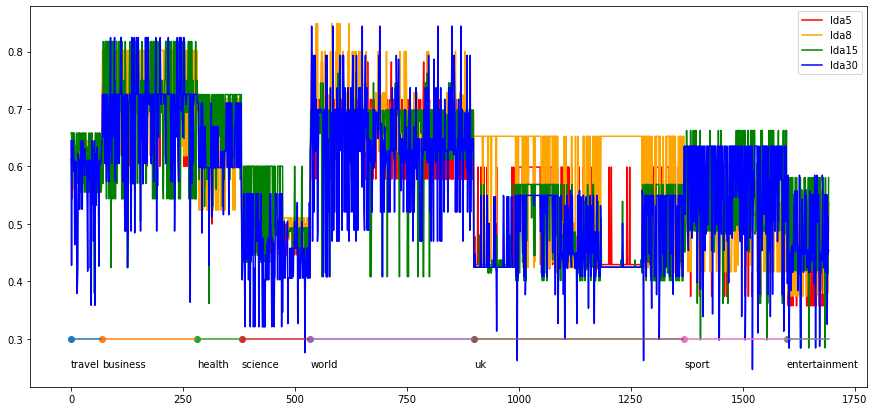

In [0]:
visualize_distances(sorted_distance_results)
len_categories = [0] + len_categories
for i in range(len(len_categories)-1):
  plt.plot([len_categories[i],len_categories[i+1]], [0.3,0.3])
  plt.scatter(len_categories[i], 0.3)
  plt.text(len_categories[i], 0.25, categories[i])
plt.show()

## Вывод

Как можно увидеть, ближе всего к реальной теме определяются статьи, связанные с бизнесом (значение расстояния выше всего). Для них лучше всего сработал LDA на 15 темах (зеленые линии выше). Хуже всего ключевые слова определялись для темы развлечений, скорее всего, из-за обилия слов, относящихся к ней. 

Как правило, lda15 работает лучше всех остальных (облако предсказанных ключевых слов ближе всего к заданной теме по расстоянию из word2vec). Исключениями стали темы "Мир" и "Великобритания", для которых лучше себя показал lda8, а lda15 дал из рук вон плохой результат. Таким образом, наше предположение, что LDA с разбитием на 8 тем покажет лучший результат из-за того, что у нас только 8 тем, оказался верным лишь отчасти.

Однако, если учить LDA на чрезмерном количестве новостей (например, 30, синяя линия), ключевые слова станут более узкоспециализированными и отдалятся от определенных нами категорий.

# Часть 2. Классификация

Приступаем к части классификации. Импортируем всё необходимое.

In [0]:
import numpy as np
from tqdm import tqdm

from lxml import objectify, etree, html
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
import itertools
#WORD2VEC
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
#DOC2VEC
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
#CLASSIFIERS
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, f1_score, confusion_matrix

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Дублируем функцию сбора датасета из xml'лек, так как в части 1 она перетиралась. 

In [0]:
def prepare_data():
  all_data = ['output_ent.xml','catalog.xml','new_articles.xml','Zalesskaya.xml']
  all_data_upd = ['output_ent_updated.xml', 'catalog_updated.xml', 'output2.xml', 'updated_articles.xml']
  catalog = []
  #fetch all data
  for data in all_data + all_data_upd:
    xmlstr_ent = open(data).read()
    root_ent = etree.fromstring(xmlstr_ent)

    for element_lvl1 in root_ent:
        news = {}
        for element_lvl2 in element_lvl1:
            if element_lvl2.tag == 'tag':
              element_lvl2.tag = 'tags'
            txt = element_lvl2.text
            news[element_lvl2.tag] = '' if txt is None else txt

        if news['text'] not in [n['text'] for n in catalog]:
          catalog.append(news)
  for news in catalog:
    if news['category'] == 'sports':
      news['category'] = 'sport'
    if news['category'] == 'UK':
      news['category'] = 'uk'
    if news['category'] == 'Royal':
      news['category'] = 'uk'
    if news['category'] == 'Science':
      news['category'] = 'science'
    if news['category'] == 'technology':
      news['category'] = 'science'
    if news['category'] == 'World':
      news['category'] = 'world'

  categories = set([news['category'] for news in catalog])
  counts = dict.fromkeys(list(categories), 0)
  for news in catalog:
    counts.update({news['category'] : counts[news['category']] + 1})
  print(counts)

  return catalog

Берём данные.

In [0]:
data = prepare_data()

{'business': 212, 'entertainment': 94, 'uk': 470, 'travel': 70, 'health': 99, 'science': 153, 'world': 365, 'sport': 229}


## Преобразование данных

В процессе токенизации текста чистим его от стоп-слов и приводим к леммам, так как это уменьшает размерность словаря и в теории должно помочь численно объединить схожие по семантике тексты.

In [0]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english') + ['the', 'a']) 
lemmatizer = WordNetLemmatizer()

def process_docs(docs):
  processed_docs = []
  for doc in docs:
    processed_docs.append(tokenize(doc.get('text'))) 
  return processed_docs

def tokenize(text):
    sentences = nltk.sent_tokenize(text)
    tokens = []
    for sentence in sentences:
        words = tokenizer.tokenize(sentence)
        lems = [lemmatizer.lemmatize(w.lower()) for w in words]
        filt_tokens = [w.lower() for w in lems if not w in stop_words]
        tokens = tokens + filt_tokens
    return tokens

Лемматизируем тексты каждого документа в корпусе.

In [0]:
processed_data = process_docs(data)

Убеждаемся, что всё хорошо.

In [0]:
len(processed_data)

1692

In [0]:
print(processed_data[0])

['cnn', 'yangtze', 'may', 'world', 'third', 'longest', 'river', 'served', 'world', 'biggest', 'river', 'cruise', 'ship', 'victoria', 'sabrina', 'ship', 'set', 'sail', 'china', 'largest', 'inland', 'body', 'water', '2020', 'ferrying', 'passenger', 'multiple', 'province', 'providing', 'view', 'three', 'gorge', 'dam', 'u', 'based', 'company', 'victoria', 'cruise', 'tell', 'cnn', 'travel', 'victoria', 'sabrina', 'due', 'make', 'maiden', 'voyage', '2020', 'luxury', 'ship', 'combine', 'western', 'chinese', 'design', 'element', 'related', 'content', 'world', 'longest', 'cruise', 'set', 'sail', 'london', 'stateroom', 'balcony', 'open', 'air', 'observation', 'deck', 'top', 'ship', 'provide', 'plenty', 'vantage', 'point', 'opportunity', 'enjoying', 'view', 'range', 'room', 'choice', 'available', 'smallest', 'option', 'stateroom', '275', 'square', 'foot', '26', 'square', 'meter', 'largest', 'posh', 'shangri', 'la', 'suite', '915', 'square', 'foot', '85', 'square', 'meter', 'room', '1', '320', 'sq

## Word2Vec

### Подготовка корпуса из новостей для Word2Vec

Разбираем тексты из всего корпуса на предложения, чтобы в процессе эмбеддинга слова из разных предложений не пересекались.

In [0]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english') + ['the', 'a']) 
lemmatizer = WordNetLemmatizer()

def make_sentences(docs):
  processed_docs = []
  for doc in docs:
    processed_docs = processed_docs + tokenize(doc.get('text'))
  return processed_docs

def tokenize(text):
    sentences = nltk.sent_tokenize(text)
    tokens = []
    for sentence in sentences:
        words = tokenizer.tokenize(sentence)
        lems = [lemmatizer.lemmatize(w.lower()) for w in words]
        filt_tokens = [w for w in lems if not w in stop_words]
        tokens.append([w.lower() for w in filt_tokens])
    return tokens

In [0]:
sentences = make_sentences(data)

Убеждаемся, что всё хорошо. На каждый документ приходится в среднем почти 40 предложений.

In [0]:
print(len(sentences))

40480


In [0]:
print(sentences[0])

['cnn', 'yangtze', 'may', 'world', 'third', 'longest', 'river', 'served', 'world', 'biggest', 'river', 'cruise', 'ship']


### Создание модели

Создаем модель с 200-мерным пространством, учим его полученными предложениями. Окно по дефолту: 5.

In [0]:
model = Word2Vec(sentences, size=200)

Проверка адекватности построенной модели. Всё хорошо.

In [0]:
print(model.wv.most_similar('virus', topn=3))

[('spread', 0.9759364128112793), ('patient', 0.9636785984039307), ('disease', 0.9588758945465088)]


Удобная прикладная штука, которая нам абсолютно не нужна, но путь будет.

In [0]:
def word2token(word):
    try:
        return model.wv.vocab[word].index
    except KeyError:
        return 0
def token2word(token):
    return model.wv.index2word[token]

Наглядный пример для понимания структуры модели. Всё корректно.

In [0]:
token_id = word2token('virus')
print(token_id)
print(token2word(token_id))
token_vec = model.wv.syn0norm[token_id]
print(token_vec.shape)

72
virus
(200,)


### Получение векторов для представления документов из модели Word2Vec

Две вспомогательные функции. Первая берет матожидание по пришедшим словам в контексте числовых векторов, вторая обобщает первую для работы с массивом текстов.

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        # logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Получаем векторное представление документов .

In [0]:
wv_data = word_averaging_list(model.wv, processed_data)

Убеждаемся, что ничего не напутали.

In [0]:
print(wv_data.shape)

(1692, 200)


Для классификаторов шифруем названия категорий в числа.

In [0]:
categories = []
for doc in data:
    categories.append(doc.get("category"))

le = preprocessing.LabelEncoder()
le.fit(categories)

print(np.unique(categories))
print(le.transform(np.unique(categories)))

y = le.transform(categories)

['business' 'entertainment' 'health' 'science' 'sport' 'travel' 'uk'
 'world']
[0 1 2 3 4 5 6 7]


Всё зашифровали.

In [0]:
print(y.shape)

(1692,)


Делим данные на трейн и тест. Учиться будем на 80%-ах.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(wv_data, y, test_size=0.2, random_state=42)

### Классификация

Пробуем классифицировать с помощью логистической регрессии и проверяем адекватность модели метрикой F1-Score. Результаты, мягко говоря, оставляют желать лучшего.

In [0]:
model = LogisticRegression().fit(x_train, y_train)
regression_y = model.predict(x_test)

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.36900684563147923
ACCURACY  0.44542772861356933


У Random Forest получается лучше, но всё равно не то, что хотелось бы видеть.

In [0]:
model = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)
regression_y = model.predict(x_test) 

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.6235672975151384
ACCURACY  0.6253687315634219


До боли знакомый код..

In [0]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    initial_categories = ['business', 'entertainment', 'health', 'science', 'sport', 'travel', 'uk', 'world']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

Смотрим на результаты натренированного нами Word2Vec и Random Forest. Видим, что есть хорошо понятую эмбеддингом спортивную семантику слов, а также относительно неплохо поняты слова про путешествия. Но в целом это далеко не лучший результат.

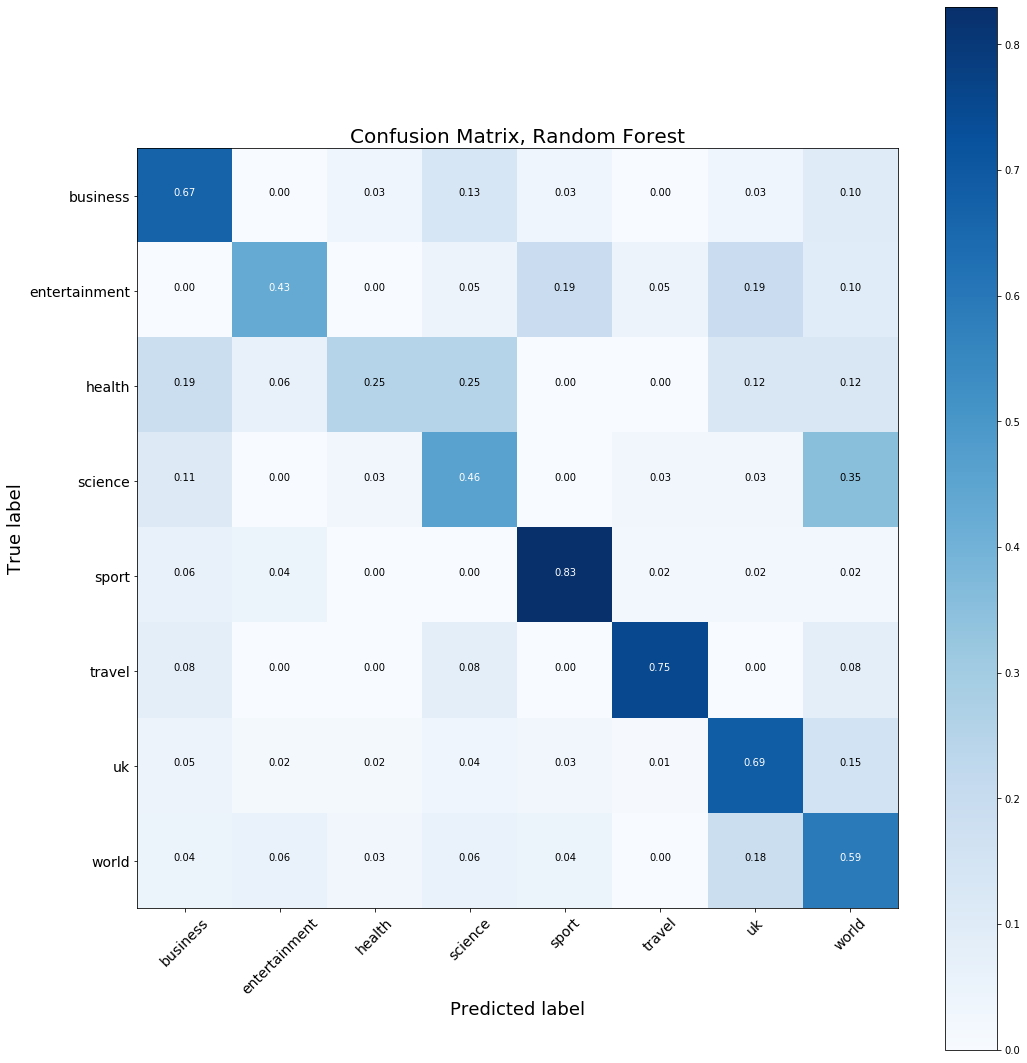

In [0]:
cmt_gbt = confusion_matrix(y_test, regression_y)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, Random Forest')

## Pre-trained Word2Vec

Возможно Word2Vec как архитектура не так плоха на самом деле, для этого мы проверим её на претрейненной модели от гугла.

### Загрузка модели

In [0]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-03-03 13:12:20--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.140.206
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.140.206|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Грузим модельку, оперативная память коллаба начинает болеть.

In [0]:
model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

Проверяем её на адекватность. Адекватно.

In [0]:
print(model.wv.most_similar('virus', topn=3))

[('flu_virus', 0.7795438766479492), ('viruses', 0.7687499523162842), ('H#N#_virus', 0.7382203340530396)]


На новой модели собираем новые описательные векторы для документов.

In [0]:
wv_data = word_averaging_list(model.wv, processed_data)

### Классификация

Разбиваем полученную информацию на трейн и тест.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(wv_data, y, test_size=0.2, random_state=42)

В этот раз случайный лес справился не так хорошо,

In [0]:
model = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)
regression_y = model.predict(x_test) 

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.7530032921854711
ACCURACY  0.7522123893805309


, как это сделала логистическая регрессия.

In [0]:
model = LogisticRegression().fit(x_train, y_train)
regression_y = model.predict(x_test)

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.7714540929307404
ACCURACY  0.775811209439528


В целом результат стал более приятным на точность, да и матричный вид тоже выглядит получше, чем было. Хуже всех была понята "наука". Наверное, потому что без науки сейчас никуда во всех остальных сферах жизни. ¯\\_(ツ)_/¯

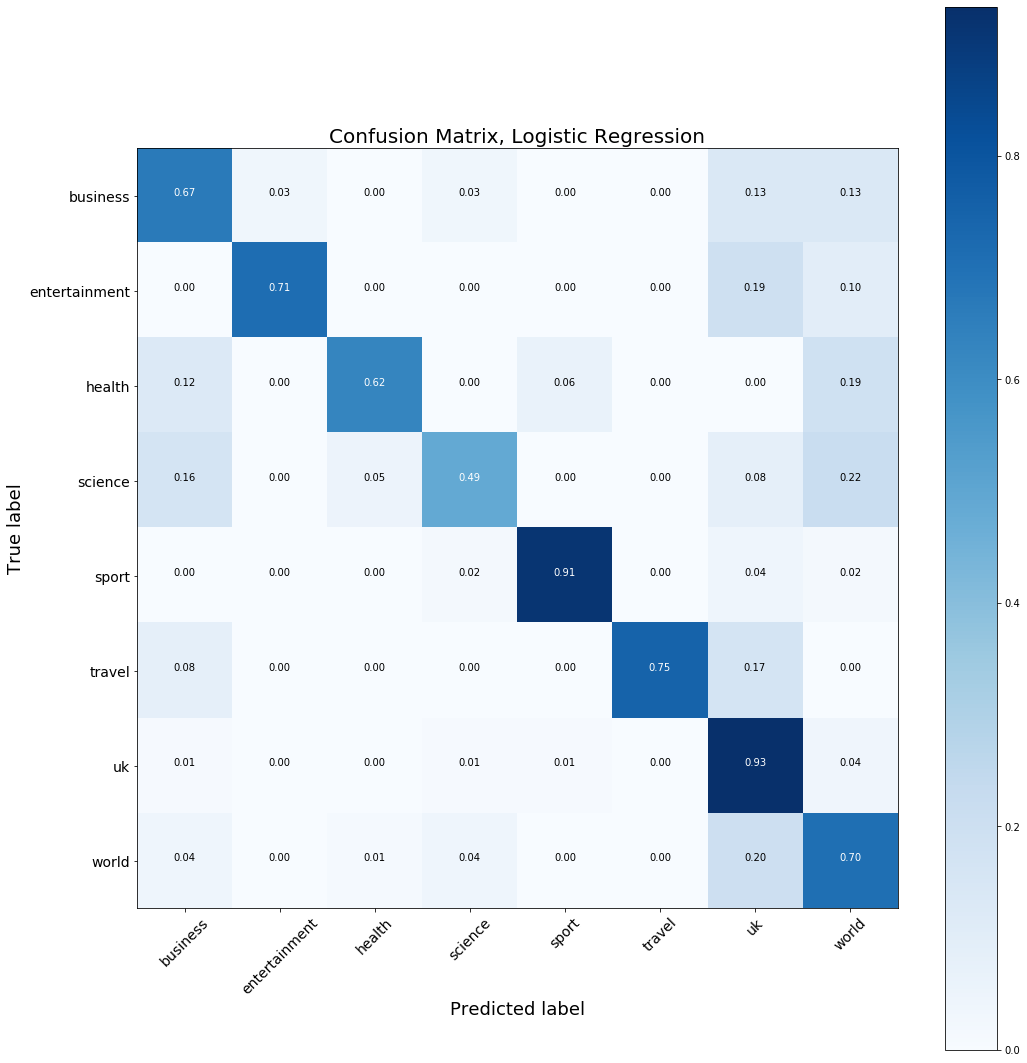

In [0]:
cmt_gbt = confusion_matrix(y_test, regression_y)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, Logistic Regression')

## Doc2Vec

Пробуем расширенную дополнительной информацией архитектуру Word2Vec: Doc2Vec. Для начала сплитим очищенные данные о документах на трейн и тест. В данную секунду не сказал бы, что делать это именно сейчас - хорошая идея, но всё уже написано и работает:)

In [0]:
xx_train, xx_test, yy_train, yy_test = train_test_split(processed_data, categories, test_size=0.2, random_state=42)

Далее с помощью специального объекта сливаем воедино информацию о текстах и о категориях документов.

In [0]:
train_tagged = []
for i in range(0, len(xx_train)):
  train_tagged.append(TaggedDocument(words=xx_train[i], tags=yy_train[i]))
test_tagged = []
for i in range(0, len(xx_test)):
  test_tagged.append(TaggedDocument(words=xx_test[i], tags=yy_test[i]))

Убеждаемся, что сделали всё правильно.

In [0]:
print(xx_train[0])

['image', 'copyright', 'reuters', 'image', 'caption', 'demonstrator', 'tuzla', 'bosnia', 'herzegovina', 'want', 'government', 'take', 'action', 'pollution', 'city', 'across', 'southern', 'europe', 'experiencing', 'dangerously', 'high', 'level', 'smog', 'caused', 'prolonged', 'period', 'dry', 'sunny', 'weather', 'light', 'wind', 'temporary', 'ban', 'diesel', 'vehicle', 'ordered', 'major', 'italian', 'city', 'including', 'capital', 'rome', 'effort', 'reduce', 'pollution', 'bosnia', 'herzegovina', 'protester', 'taken', 'street', 'gas', 'mask', 'demanding', 'action', 'government', 'environmentalist', 'described', 'situation', 'smog', 'emergency', 'rome', 'diesel', 'car', 'van', 'motorbike', 'banned', 'peak', 'time', 'polluting', 'vehicle', 'banned', 'altogether', 'restriction', 'set', 'remain', 'place', 'next', 'three', 'day', 'expected', 'affect', 'one', 'million', 'vehicle', 'least', 'nine', '13', 'area', 'rome', 'monitor', 'particulate', 'matter', 'fine', 'dust', 'known', 'pm10', 'recor

In [0]:
print(len(xx_train))
print(train_tagged[0])

1353
TaggedDocument(['image', 'copyright', 'reuters', 'image', 'caption', 'demonstrator', 'tuzla', 'bosnia', 'herzegovina', 'want', 'government', 'take', 'action', 'pollution', 'city', 'across', 'southern', 'europe', 'experiencing', 'dangerously', 'high', 'level', 'smog', 'caused', 'prolonged', 'period', 'dry', 'sunny', 'weather', 'light', 'wind', 'temporary', 'ban', 'diesel', 'vehicle', 'ordered', 'major', 'italian', 'city', 'including', 'capital', 'rome', 'effort', 'reduce', 'pollution', 'bosnia', 'herzegovina', 'protester', 'taken', 'street', 'gas', 'mask', 'demanding', 'action', 'government', 'environmentalist', 'described', 'situation', 'smog', 'emergency', 'rome', 'diesel', 'car', 'van', 'motorbike', 'banned', 'peak', 'time', 'polluting', 'vehicle', 'banned', 'altogether', 'restriction', 'set', 'remain', 'place', 'next', 'three', 'day', 'expected', 'affect', 'one', 'million', 'vehicle', 'least', 'nine', '13', 'area', 'rome', 'monitor', 'particulate', 'matter', 'fine', 'dust', 'kn

### Создание модели Doc2Vec

Создаём модели и сообщаем ей общий для всех тренировочных данных вокабуляр.

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 1353/1353 [00:00<00:00, 1020847.87it/s]


Учим модельку 10 эпох с понижением LR на 0.002 в каждой эпохе.

In [0]:
for epoch in range(10):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged)]), total_examples=len(train_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1353/1353 [00:00<00:00, 537598.84it/s]


Теперь нам надо эту информацию привести к формату для классификации, чем мы и занимаемся.

In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

Привели.

In [0]:
y_train, x_train = vec_for_learning(model_dbow, train_tagged)
y_test, x_test = vec_for_learning(model_dbow, test_tagged)

Классы на месте.

In [0]:
print(np.unique(y_test + y_train))

['business' 'entertainment' 'health' 'science' 'sport' 'travel' 'uk'
 'world']


### Классификация

Поставлен локальный рекорд по точности с помощью логистической регрессии.

In [0]:
model = LogisticRegression().fit(x_train, y_train)
regression_y = model.predict(x_test)

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.8167654263460772
ACCURACY  0.8171091445427728


Но, к сожалению(нет), случайный лес этот рекорд тут же побил.

In [0]:
model = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)
regression_y = model.predict(x_test) 

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.8349354503311782
ACCURACY  0.8348082595870207


Оценка: в целом это уже хороший репрезентабельный результат, которым можно довольствоваться. Картину портит категория "здоровье", которая относительно часто путается с "миром". В принципе, в свете последний событий это не очень-то удивительно.

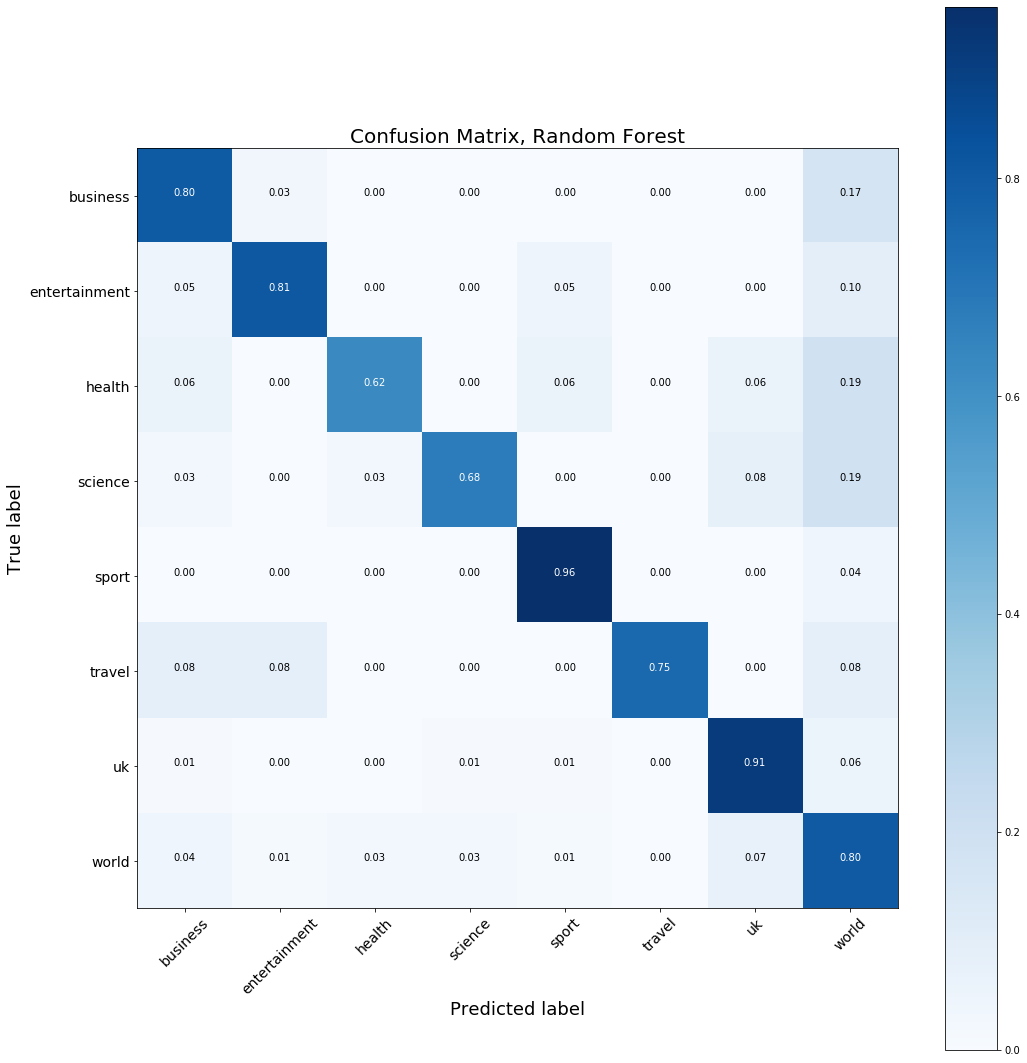

In [0]:
cmt_gbt = confusion_matrix(y_test, regression_y)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, Random Forest')

## Glove

Смотрим, что еще может помочь нам улучшить точность. Glove. Годится, качаем.

In [0]:
!pip install glove_python

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700329 sha256=8c654a7955aed82318afdd2177c2c3f35280e37c107b4fdd2da4283577600fa5
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


### Тренировка

In [0]:
from glove import Corpus, Glove

Это вспомогательная штука для представления наших данных в удобном для Glove-модели формате.

In [0]:
corpus = Corpus()
corpus.fit(sentences, window=10)

Создаем модель, размерность пространства: 200, LR: 0.05, учим 10 эпох.

In [0]:
glove_model = Glove(no_components=200, learning_rate=0.05)
glove_model.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)
glove_model.add_dictionary(corpus.dictionary)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


Чуть подкорректированная под обстоятелсьтва функция обобщения документов по векторам слов.

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.dictionary:
            mean.append(wv.word_vectors[wv.dictionary[word]])
            # all_words.add(wv.vocab[word].index)

    if not mean:
        # logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.word_vectors.shape[1])

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

Получили векторную информацию о документах.

In [0]:
glove_data = word_averaging_list(glove_model, processed_data)

Убедились, что всё в порядке.

In [0]:
glove_data.shape

(1692, 200)

### Классификация

Собрали трейн и тест из Glove-матрицы.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(glove_data, y, test_size=0.2, random_state=42)

Сравнивая с Word2Vec, Glove немного лучше (на 4%), но в целом практика показала, что обучение только на собственном датасете и там и там весьма не убедительное.

In [0]:
model = LogisticRegression().fit(x_train, y_train)
regression_y = model.predict(x_test)

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.41975730445416004
ACCURACY  0.49852507374631266


Случайный лес поднял точность, но не дотянул и до Word2Vec.

In [0]:
model = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)
regression_y = model.predict(x_test) 

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.5803602024038264
ACCURACY  0.5899705014749262


Глядя на матрицу, складывается впечатление, что алгоритм заучился на пару-тройку категорий, которые ему лучше всего понятны, и устремился в них ради уменьшения функции ошибки. Здесь "пара-тройка" категорий несёт отрицательный сентемент, так как всего категорий 8.

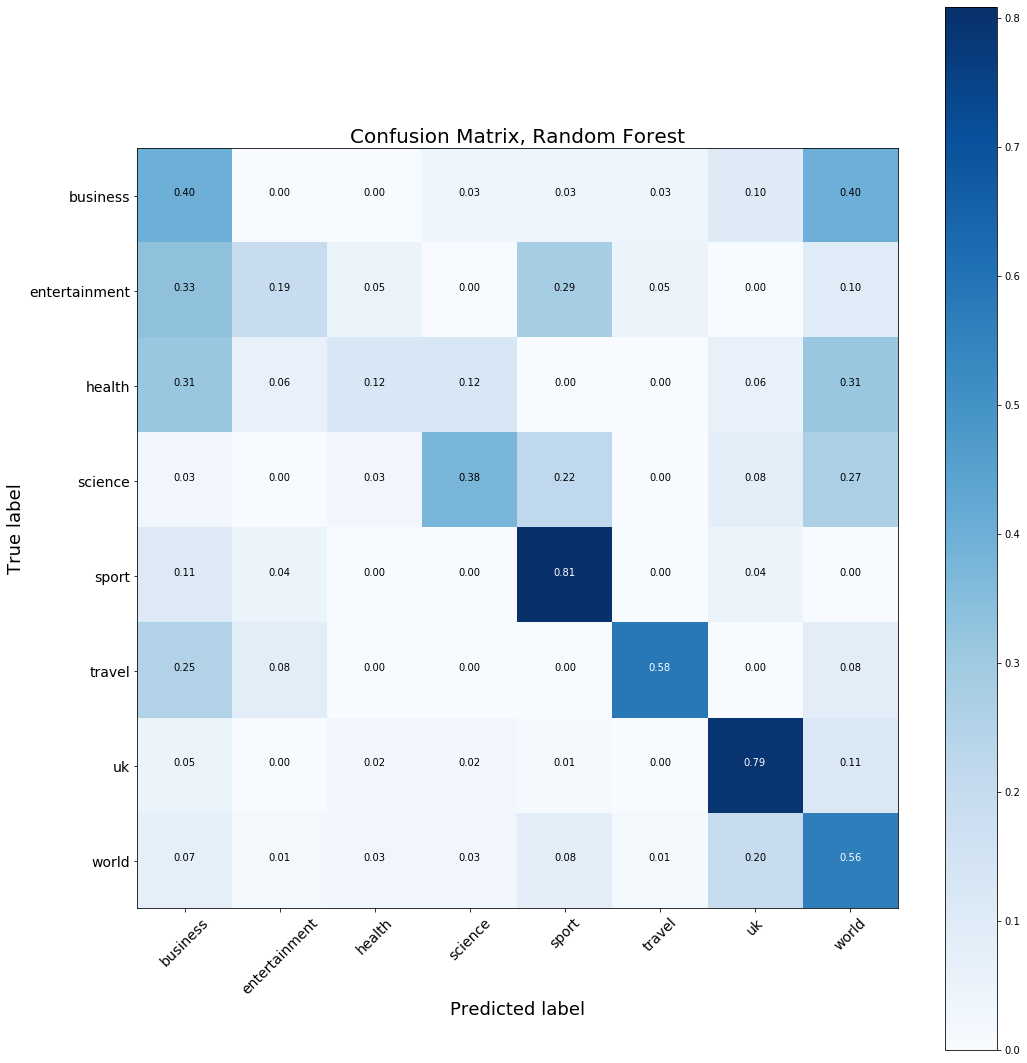

In [0]:
cmt_gbt = confusion_matrix(y_test, regression_y)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, Random Forest')

## Pre-trained Glove

Как и в случае с Word2Vec, стоит понадеяться на хорошие результаты с предобученной моделью Glove.

### Загрузка модели

Предобученных моделей для Glove много, они различаются размерностями и размерами, мы берём относительно компактную версию.

In [0]:
glove_vecSize = 200
!cp drive/'My Drive'/Lab5_data/'glove.6B.200d.txt' .

У Glove отличный от других моделей формат хранения данных, поэтому под него пришлось отдельно подстраиваться.

In [0]:
embeddings_dict = {}
with open("glove.6B."+str(glove_vecSize)+"d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

Еще одна адаптация уже реализованных ранее функций.

In [0]:
def word_averaging_glove(glove, words):
        mean = [np.zeros(glove_vecSize)]
        for word in words:
            if word in glove:
                mean.append(glove[word])
        return np.mean(mean, axis=0).astype(np.float32)
        
def  word_averaging_list_glove(wv, text_list):
    return np.vstack([word_averaging_glove(wv, post) for post in text_list ])

Сабираем данные по документам через новую модель.

In [0]:
glove_data = word_averaging_list_glove(embeddings_dict, processed_data)

Размер корректен.

In [0]:
print(glove_data.shape)

(1692, 200)


### Классификация

Сплитим.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(glove_data, y, test_size=0.2, random_state=42)

Случайный лес. Результат неплох, но и не хорош.

In [0]:
model = RandomForestClassifier(n_estimators=500).fit(x_train, y_train)
regression_y = model.predict(x_test) 

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.7669599754985197
ACCURACY  0.7669616519174042


Логистическая регрессия. Результат хорош, но бывало и лучше.

In [0]:
model = LogisticRegression().fit(x_train, y_train)
regression_y = model.predict(x_test)

print("F1-SCORE ", f1_score(y_test, regression_y, average='weighted')) 
print("ACCURACY ", accuracy_score(y_test, regression_y))

F1-SCORE  0.8174190314160625
ACCURACY  0.8200589970501475


Ошибки в классификации не сильно отличаются от предыдущих случаев, полагаю, нет смысла что-либо здесь обсуждать.

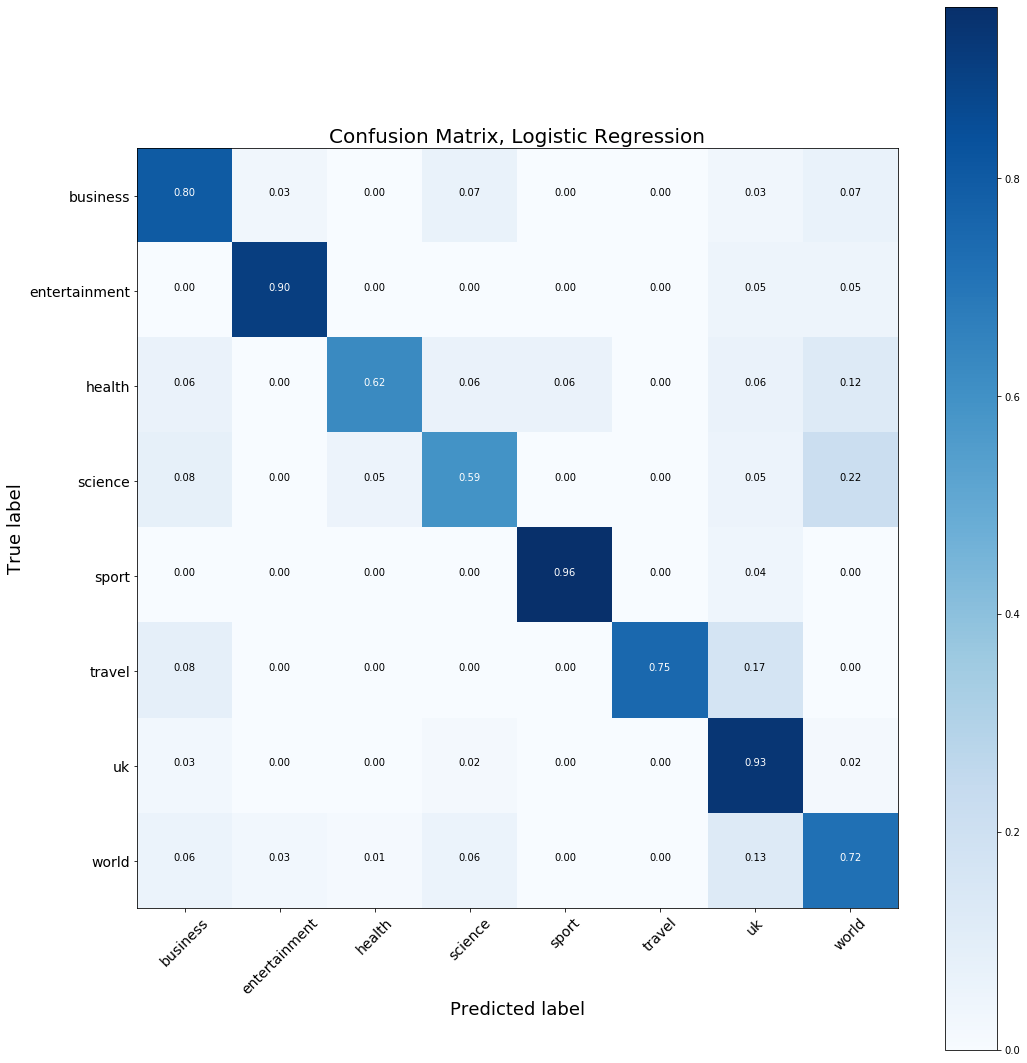

In [0]:
cmt_gbt = confusion_matrix(y_test, regression_y)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, Logistic Regression')

## FastText (нет)

Мы честно пытались припилить сюда еще и FastText, но библиотека и инструменты работы с ней оказались крайне недружелюбными, имхо. Первым делом смутил формат ввода данных: указать путь к текстовому файлу, внутри которого построчно размеченны категории с помощью мета-тегов "_label_myCategoryExample" и всё, иначе данные никак не залить. Окей, с горем пополам форматировали наш датасет под эту ересь и записали всё в тектовый файл. Потом оказалось, что тестирование модели происходит тем же способом, то есть для трейна и теста надо иметь два разных текстовых файла. Захотели поменять соотношение трейн\тест с 80%-20% на 70%-30% - пересобирайте текстовые файлы. Потом выяснилось, что часть функций библиотеки не безопасны и способны не выдавать лог об ошибке, а просто крашиться, крашить сеанс работы в коллабе и перезапускать коллаб-машину с потерей всей загруженной в RAM информации, то есть придётся потом еще все блоки кода перепрогонять. Даже это, окей, осилили, но видимо не совсем корректно, потому что итоговая точность на нашем датасете - 30%. На этой ноте идея с FastText была дропнута. Прошу прощения за лонгрид.

## Попытка улучшить результаты

Всё, остались только попытки прокнуть лучшую точность. Собираем большую функцию, вмещающую в себя все интересующие и даже не интересующие нас гиперпараметры, которая будет строить Doc2Vec модель и классифицировать документы через случайный лес и полный комплект вариаций solver'ов логистической регрессии.

In [0]:
import multiprocessing

cpu_count = multiprocessing.cpu_count()

def f(nsize, window_size, hs, negatives, n_epochs, rf_estimators, lr, lrd): # lrd - learning rate decrease
    model_dbow = Doc2Vec(dm=0, vector_size=nsize, negative=negatives, hs=hs, min_count=2, sample = 0, workers=cpu_count)
    model_dbow.build_vocab([x for x in tqdm(train_tagged)])

    model_dbow.alpha = lr
    for epoch in range(n_epochs):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged)]), total_examples=len(train_tagged), epochs=1)
        model_dbow.alpha -= lrd
        model_dbow.min_alpha = model_dbow.alpha

    y_train, x_train = vec_for_learning(model_dbow, train_tagged)
    y_test, x_test = vec_for_learning(model_dbow, test_tagged)

    solvers = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
    accuracies = []
    logist_reg_pred = []
    best = 0
    best_solver = 0
    for i in solvers:
        if(i == 'liblinear'):
            model = LogisticRegression(solver=i, penalty="l2").fit(x_train, y_train)
        else:
            model = LogisticRegression(solver=i).fit(x_train, y_train)
        regression_y = model.predict(x_test)
        acc = accuracy_score(y_test, regression_y)
        accuracies.append(acc)
        # print('Solver ', i, 'Accuracy', acc)
        if(best < acc):
            best = acc
            best_solver = i
            logist_reg_pred = regression_y
    # print("BEST SCORE", best)

    model = RandomForestClassifier(n_estimators=rf_estimators).fit(x_train, y_train)
    regression_y = model.predict(x_test) 
    acc = accuracy_score(y_test, regression_y)
    if(best < acc):
        best = acc
        best_solver = 'RandomForest'
        logist_reg_pred = regression_y

    print('Solver=', best_solver, ' F1 Score=', f1_score(y_test, logist_reg_pred, average='weighted'), ' Accuracy',best)
    return best, logist_reg_pred

Восстанавливаем то, что было лучшим в процессе имплементации моделей. 84%. Локальный рекорд.

In [0]:
acc, reg_y = f(nsize=200, window_size=5, hs=0, negatives=5, n_epochs=10, rf_estimators=500, lr=0.011, lrd=0.001)

100%|██████████| 1353/1353 [00:00<00:00, 1391246.22it/s]


Solver= RandomForest  F1 Score= 0.8416373020838165  Accuracy 0.8407079646017699


Смотрим, что будет, если увеличить размерность пространства. Стало лучше на 0.3%. Stonks.

In [0]:
acc, reg_y = f(nsize=300, window_size=5, hs=0, negatives=5, n_epochs=10, rf_estimators=500, lr=0.011, lrd=0.001)

100%|██████████| 1353/1353 [00:00<00:00, 1705196.31it/s]


Solver= RandomForest  F1 Score= 0.8442206840815919  Accuracy 0.8436578171091446


В предположении, что больше - лучше, получаем ситуацию, когда такое предположение неверно.

In [0]:
acc, reg_y = f(nsize=400, window_size=5, hs=0, negatives=5, n_epochs=10, rf_estimators=500, lr=0.011, lrd=0.001)

100%|██████████| 1353/1353 [00:00<00:00, 404857.91it/s]


Solver= RandomForest  F1 Score= 0.8239600769347829  Accuracy 0.8230088495575221


Еще можно предположить, что если увеличить окно для Doc2Vec, то семантика слов начнёт высчитываться лучше и вообще жить станет приятнее, но это тоже не так.

In [0]:
acc, reg_y = f(nsize=300, window_size=6, hs=0, negatives=5, n_epochs=10, rf_estimators=500, lr=0.011, lrd=0.001)

100%|██████████| 1353/1353 [00:00<00:00, 955208.43it/s]


Solver= RandomForest  F1 Score= 0.8414383701585647  Accuracy 0.8407079646017699


В итоге к нам пришло смирение с гипотезой о том, что ~84% - наш потолок либо по причине нашей некомпетентности в вопросе решения задачи классификации, либо же наш датасет был слишком грубо смёржен по категориям. В целом, мы попытались, это хороший опыт.

# Часть 3. The END?

Это была очень длинная, довольно тяжелая, но очень интересная лаба. Один список тем слева в коллабе чего стоит. Ух! А тебе это еще и проверять D:

Но если ты дошел до сюда, то, видимо, уже закончил. Танцуем!  

![](https://media.giphy.com/media/WVFKHDl0cm4BToZGyb/giphy.gif)